In [2]:
%pip install numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


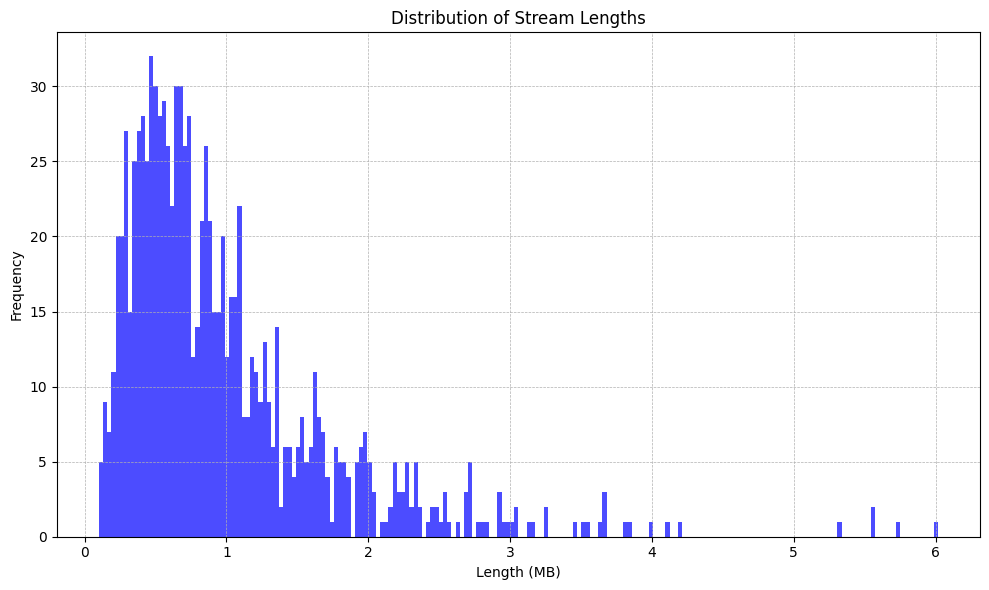

In [3]:
import numpy as np

# Parameters for the lognormal distribution
num_arrays = 1000
mode = 800*1024
mean = 1*1024*1024

mu = np.log(mode)
sigma = np.sqrt(2*(np.log(mean) - mu))

# Generate the lengths
lengths = np.random.lognormal(mean=mu, sigma=sigma, size=num_arrays).astype(int)

# Cap at 10MB
lengths = np.minimum(lengths, 10*1024*1024)

# Generate the bytearrays
byte_arrays = [bytearray(np.random.rand(l)) for l in lengths]

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(lengths / (1024*1024), bins=200, color='blue', alpha=0.7)  # Convert lengths to MB for plotting
plt.title('Distribution of Stream Lengths')
plt.xlabel('Length (MB)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [4]:
import binascii
from pyeclib.ec_iface import ECDriver

# Instantiate ECDriver
ec_driver = ECDriver(k=6, m=2, ec_type='liberasurecode_rs_vand')

# Encode data
data_to_encode = bytes.fromhex('11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111')
encoded_data = ec_driver.encode(data_to_encode)

print(f"Size of original data: {len(data_to_encode)} bytes")

for idx, chunk in enumerate(encoded_data):
    hex_chunk = binascii.hexlify(chunk).decode('utf-8')
    print(f"Size of encoded data: chunk({idx}) {len(chunk)} bytes")
    print(f"Encoded chunk {idx}: {hex_chunk}")

ModuleNotFoundError: No module named 'pyeclib'

In [6]:
def calculate_thresholds(km_pairs, overhead):
    thresholds = {}
    for K, M in km_pairs:
        try:
            data_size_threshold = (overhead * (K + M) * K) / (M - ((K + M) / K))
            thresholds[(K, M)] = data_size_threshold
        except ZeroDivisionError:
            thresholds[(K, M)] = float('inf')  # FEC never beneficial
    return thresholds

km_pairs = [(4, 2), (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 4)]  # Example setups
overhead = 80  # Overhead per strip
thresholds = calculate_thresholds(km_pairs, overhead)

for km, threshold in thresholds.items():
    print(f"Optimal threshold for {km[0]}+{km[1]} setup: {threshold:.2f} bytes")


Optimal threshold for 4+2 setup: 3840.00 bytes
Optimal threshold for 6+2 setup: 5760.00 bytes
Optimal threshold for 8+2 setup: 8533.33 bytes
Optimal threshold for 10+2 setup: 12000.00 bytes
Optimal threshold for 12+2 setup: 16128.00 bytes
Optimal threshold for 14+2 setup: 20906.67 bytes
Optimal threshold for 16+4 setup: 9309.09 bytes


In [7]:
def calculate_max_incoming_bandwidth(K, M, total_bandwidth=1e9):  # 1 Gbit in bits
    # Calculate for FEC
    incoming_fec = total_bandwidth * (K / (K + M))
    
    # Calculate for Replication
    incoming_rep = total_bandwidth / (M + 1)
    
    return incoming_fec, incoming_rep

# Define a set of popular K + M combinations
configurations = [
    (4, 2),
    (6, 2),
    (8, 2),
    (10, 2),
    (10, 3),
    (12, 3),
    (14, 3),
    (16, 4)
]

# Iterate over each configuration
for K, M in configurations:
    incoming_fec, incoming_rep = calculate_max_incoming_bandwidth(K, M)
    print(f"For {K}+{M} configuration:")
    print(f"  FEC approach: Maximum incoming bandwidth is {incoming_fec/1e9:.3f} Gbit")
    print(f"  Replication approach: Maximum incoming bandwidth is {incoming_rep/1e9:.3f} Gbit\n")


For 4+2 configuration:
  FEC approach: Maximum incoming bandwidth is 0.667 Gbit
  Replication approach: Maximum incoming bandwidth is 0.333 Gbit

For 6+2 configuration:
  FEC approach: Maximum incoming bandwidth is 0.750 Gbit
  Replication approach: Maximum incoming bandwidth is 0.333 Gbit

For 8+2 configuration:
  FEC approach: Maximum incoming bandwidth is 0.800 Gbit
  Replication approach: Maximum incoming bandwidth is 0.333 Gbit

For 10+2 configuration:
  FEC approach: Maximum incoming bandwidth is 0.833 Gbit
  Replication approach: Maximum incoming bandwidth is 0.333 Gbit

For 10+3 configuration:
  FEC approach: Maximum incoming bandwidth is 0.769 Gbit
  Replication approach: Maximum incoming bandwidth is 0.250 Gbit

For 12+3 configuration:
  FEC approach: Maximum incoming bandwidth is 0.800 Gbit
  Replication approach: Maximum incoming bandwidth is 0.250 Gbit

For 14+3 configuration:
  FEC approach: Maximum incoming bandwidth is 0.824 Gbit
  Replication approach: Maximum incoming

In [8]:
import os

class DynamicContentFile:
    def __init__(self, total_size, chunk_size=16384):
        self.total_size = total_size
        self.chunk_size = chunk_size
        self.generated = 0

    def read(self, size=-1):
        if size < 0:
            size = self.chunk_size
        if self.generated >= self.total_size:
            return b''  # No more data to generate

        to_generate = min(self.total_size - self.generated, size)
        self.generated += to_generate
        return os.urandom(to_generate)
    
dynamic_content = DynamicContentFile(16384 * 10)
i = 0
while True:
    content = dynamic_content.read()
    if content == b'':
        break
    i+=len(content)
    print(i)



16384
32768
49152
65536
81920
98304
114688
131072
147456
163840


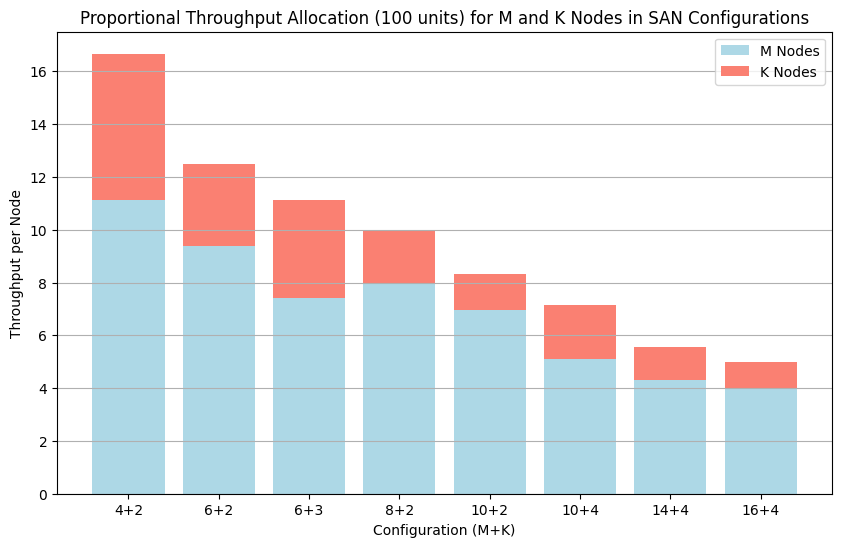

In [16]:
# Configurations (M+K)
configurations = ['4+2', '6+2', '6+3', '8+2', '10+2', '10+4', '14+4', '16+4']

# Extract M and K values from configurations and calculate total nodes for each
total_nodes = [sum(map(int, config.split('+'))) for config in configurations]

# Splitting the configurations into M and K values
M_values = [int(config.split('+')[0]) for config in configurations]
K_values = [int(config.split('+')[1]) for config in configurations]


# Assume total throughput of the SAN is a fixed value, e.g., 100 units
total_throughput = 100

# Calculate throughput per node for each configuration
throughput_per_node = [total_throughput / nodes for nodes in total_nodes]

# Calculate the proportion of throughput for M and K in each configuration
proportion_M = [M / (M + K) for M, K in zip(M_values, K_values)]
proportion_K = [K / (M + K) for M, K in zip(M_values, K_values)]

# Calculate the heights of M and K segments for each bar
height_M = [prop * throughput for prop, throughput in zip(proportion_M, throughput_per_node)]
height_K = [prop * throughput for prop, throughput in zip(proportion_K, throughput_per_node)]

# Plotting with proportional segments
plt.figure(figsize=(10, 6))
bar_M = plt.bar(configurations, height_M, color='lightblue', label='M Nodes')
bar_K = plt.bar(configurations, height_K, color='salmon', label='K Nodes', bottom=height_M)

plt.xlabel('Configuration (M+K)')
plt.ylabel('Throughput per Node')
plt.title('Proportional Throughput Allocation (100 units) for M and K Nodes in SAN Configurations')
plt.legend()
plt.grid(axis='y')
plt.show()
